# Analysis of piano performances through MIDI data

This notebook presents some preliminary analysis on how to extract performance measures by analyzing MIDI files. More specifically, we focus on performances of classical music pieces, and on the interpretation of velocity values.

Notebook prepared by Lorenzo Romanelli.

### Objectives

What we are trying to understand is how to get quantitative data that closely relates to music performance. This is partly motivated due to the necessity to have some (more or less) objective metrics against which to compare more subjective evaluations, such as expressivity, interpretation, or beauty.

In this particular scenario, we have at disposal some incredibly useful raw data of different performances of the same music piece (*Jeux d'eau* by Maurice Ravel, piece composed in 1901). This data is provided to us in the form of MIDI files extracted from the performances of three different interpreters: Ran Jia, Denis Zhdanov, and Valerie Narumi. All of these performers played the piece on the Yamaha's Disklavier, a traditional acoustic piano which features the remarkable plus of allowing the recording (and the playback) of MIDI data.

In [1]:
# Import modules
import os
import numpy as np
import urllib.request as req
import matplotlib.pyplot as plt
import music21 as m21
from math import floor
from scipy.signal import resample_poly
%matplotlib inline

### Dataset

While we do have performance-specific data, we want to compare them to some sort of "ground-truth" performance. It is of course impossible to obtain a completely objective ground-truth played by some human performer. Thus, we will use an automatically generated MIDI rendition of the piece, generated by a transcription software.

In [2]:
# Create data directory if it doesn't exist
data_dir = 'dataset'
if not os.path.exists(data_dir):
    os.mkdir(data_dir);

perf_url = 'http://www.yamahaden.com/midi-files?task=callelement&format=raw&item_id={}&element=934c16ca-6314-4c8d-a8c7-164439488b1f&method=download'
# Metadata and urls for the MIDI files
# (ground truth and various performances)
urls = {
    'ground_truth': 'http://www.piano-midi.de/midis/ravel/rav_eau.mid',
    'performances': [
        {
            'performer': 'Ran Jia',
            'date': 'June 30th 2009',
            'url': perf_url.format('1699'),
            'filename': 'jia09.mid'
        },
        {
            'performer': 'Denis Zhdanov',
            'date': 'July 2nd 2009',
            'url': perf_url.format('1700'),
            'filename': 'zhdanov09.mid'
        },
        {
            'performer': 'Valerie Narumi',
            'date': 'July 7th 2013',
            'url': perf_url.format('2242'),
            'filename': 'narumi13.mid'
        },
    ]
}

filenames = [data_dir + '/' + perf['filename'] for perf in urls['performances']]
ground_truth = data_dir + '/ground_truth.mid'

# Download the data
# (ground truth and performances)
for k, val in urls.items():
    if k == 'ground_truth':
        url = val
        req.urlretrieve(url, data_dir + '/ground_truth.mid')
    else:
        for performance in val:
            url = performance['url']
            filename = data_dir + '/' + performance['filename']
            req.urlretrieve(url, filename)

We will focus on velocity data. However, information about notes and pitches contained in the MIDI files can be quite useful anyways.

In [3]:
def parseMIDI(filename):
    '''
    Converts a MIDI file into a music21 stream.
    '''
    stream = m21.converter.parse(filename)
    return stream

def getNotesAndPitches(stream):
    '''
    Returns all the note objects (including chords)
    and all the individual pitches.
    '''
    notes = stream.flat.notes
    return notes, notes.pitches

def getVelocities(stream, window_size, overlap):
    '''
    Returns two lists, containing the velocities of the single notes
    and a windowed version of the velocities (useful for later analysis).
    '''
    assert 0 <= overlap < 1, "Overlap size should be between 0 and 1."
    w = window_size
    o = int(floor(w*overlap))
    notes = stream.flat.notes
    velocities = [note.volume.velocity for note in notes]
    windowed = [velocities[i:i+w] for i in range(0, len(velocities), w-o)]
    return (velocities, windowed)

In [4]:
# Convert ground truth and performances into
# music21 streams.

gt_stream = parseMIDI(ground_truth)
streams = [gt_stream]
streams.extend([parseMIDI(filename) for filename in filenames])

What we want to do is to analyze how the velocities of the notes evolve as the music piece develops. To do so we will group notes according to a window, and we will then compute the mean and the standard deviation for each window. An overlapping factor allows us to have a smoother representation of the notes stream.

**Note:** differently from the audio domain, a window here groups together a fixed number of note events, ignoring the time dimension (in the sense that windows might cover different timespans, depending on the duration of the notes they contain).

One problem here is that each performance is of different length with respect to the others, so we will need to rescale all the note streams up (or down) to a size comparable to the size of the ground-truth.

In [5]:
window_size = 50
overlap = 0.5
perf_velocities = [getVelocities(stream, window_size, overlap) for stream in streams]
vel_means = [[np.mean(vel) for vel in performance[1]] for performance in perf_velocities]
vel_stds = [[np.std(vel) for vel in performance[1]] for performance in perf_velocities]

# Resample all the vectors of means and stdevs
# so they're all of size equal to the ground truth
resample_size = len(vel_means[0])
res_means = []
res_stds = []
for vm in vel_means[1:]:
    old_len = len(vm)
    interp = resample_poly(vm, resample_size*2, old_len*2)
    res_means.append(interp)
for vs in vel_stds[1:]:
    old_len = len(vs)
    interp = resample_poly(vs, resample_size*2, old_len*2)
    res_stds.append(interp)

### Visualization of the results

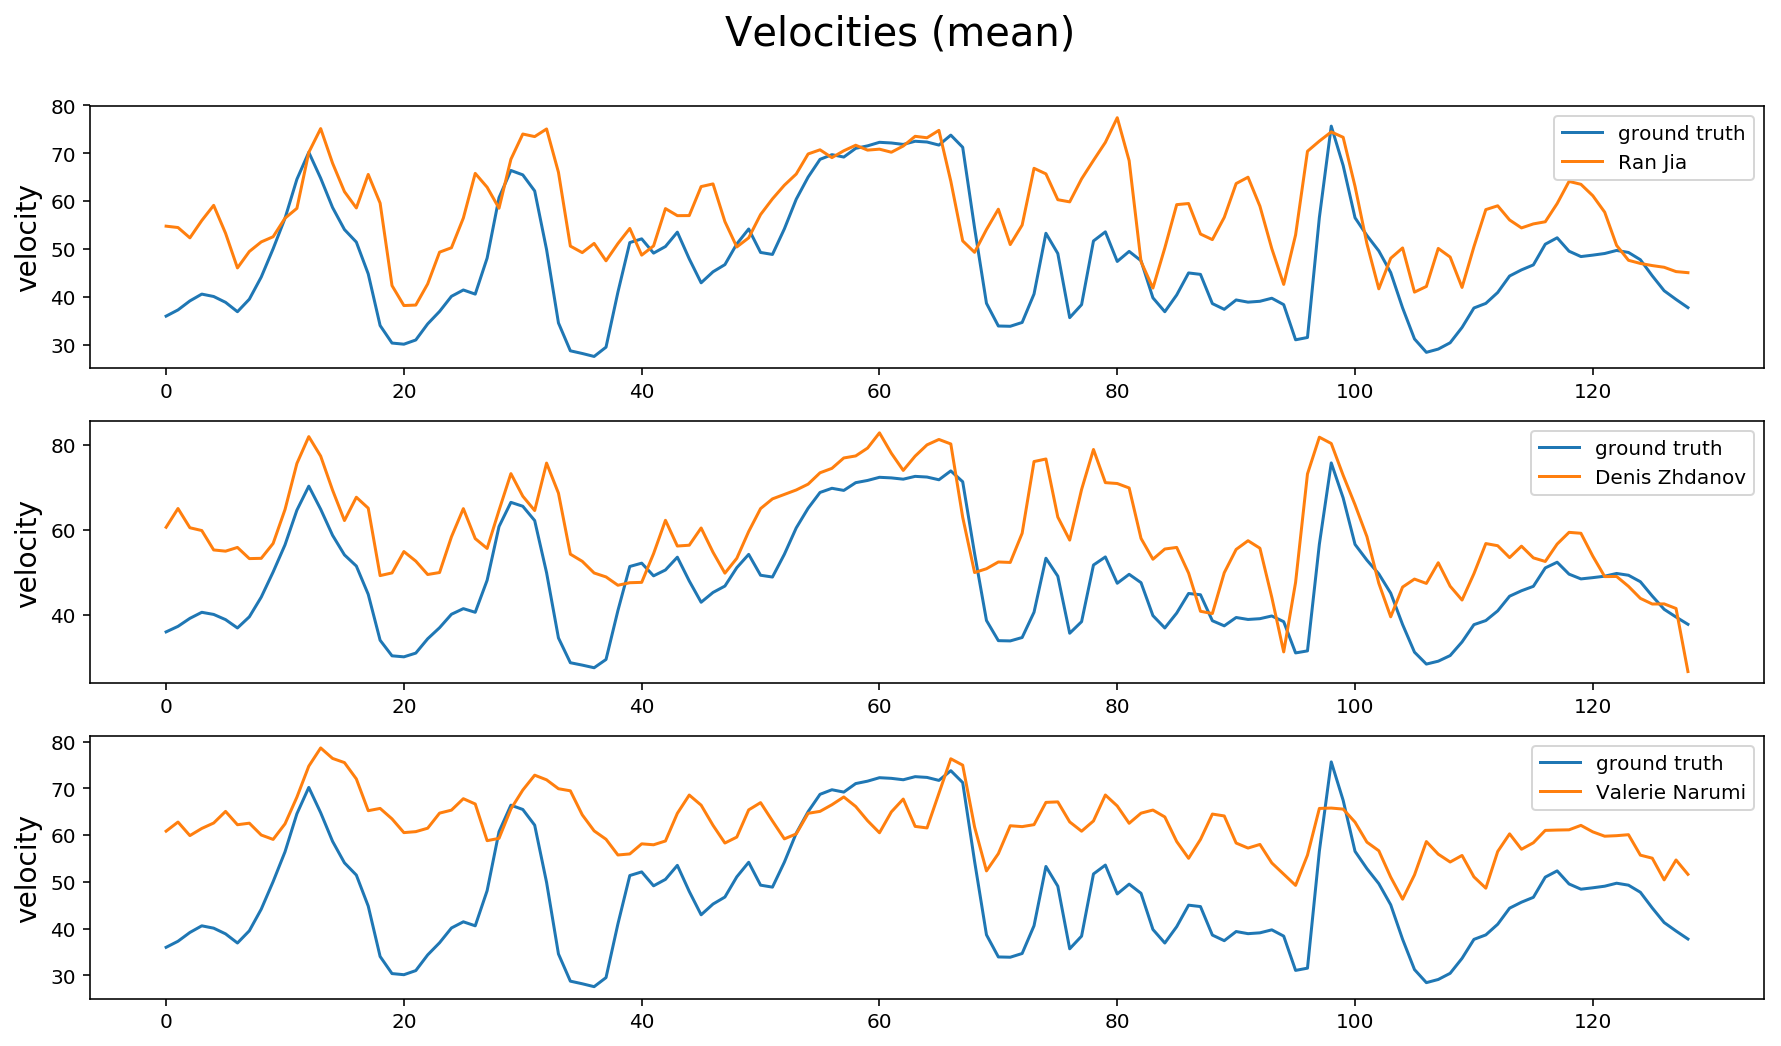

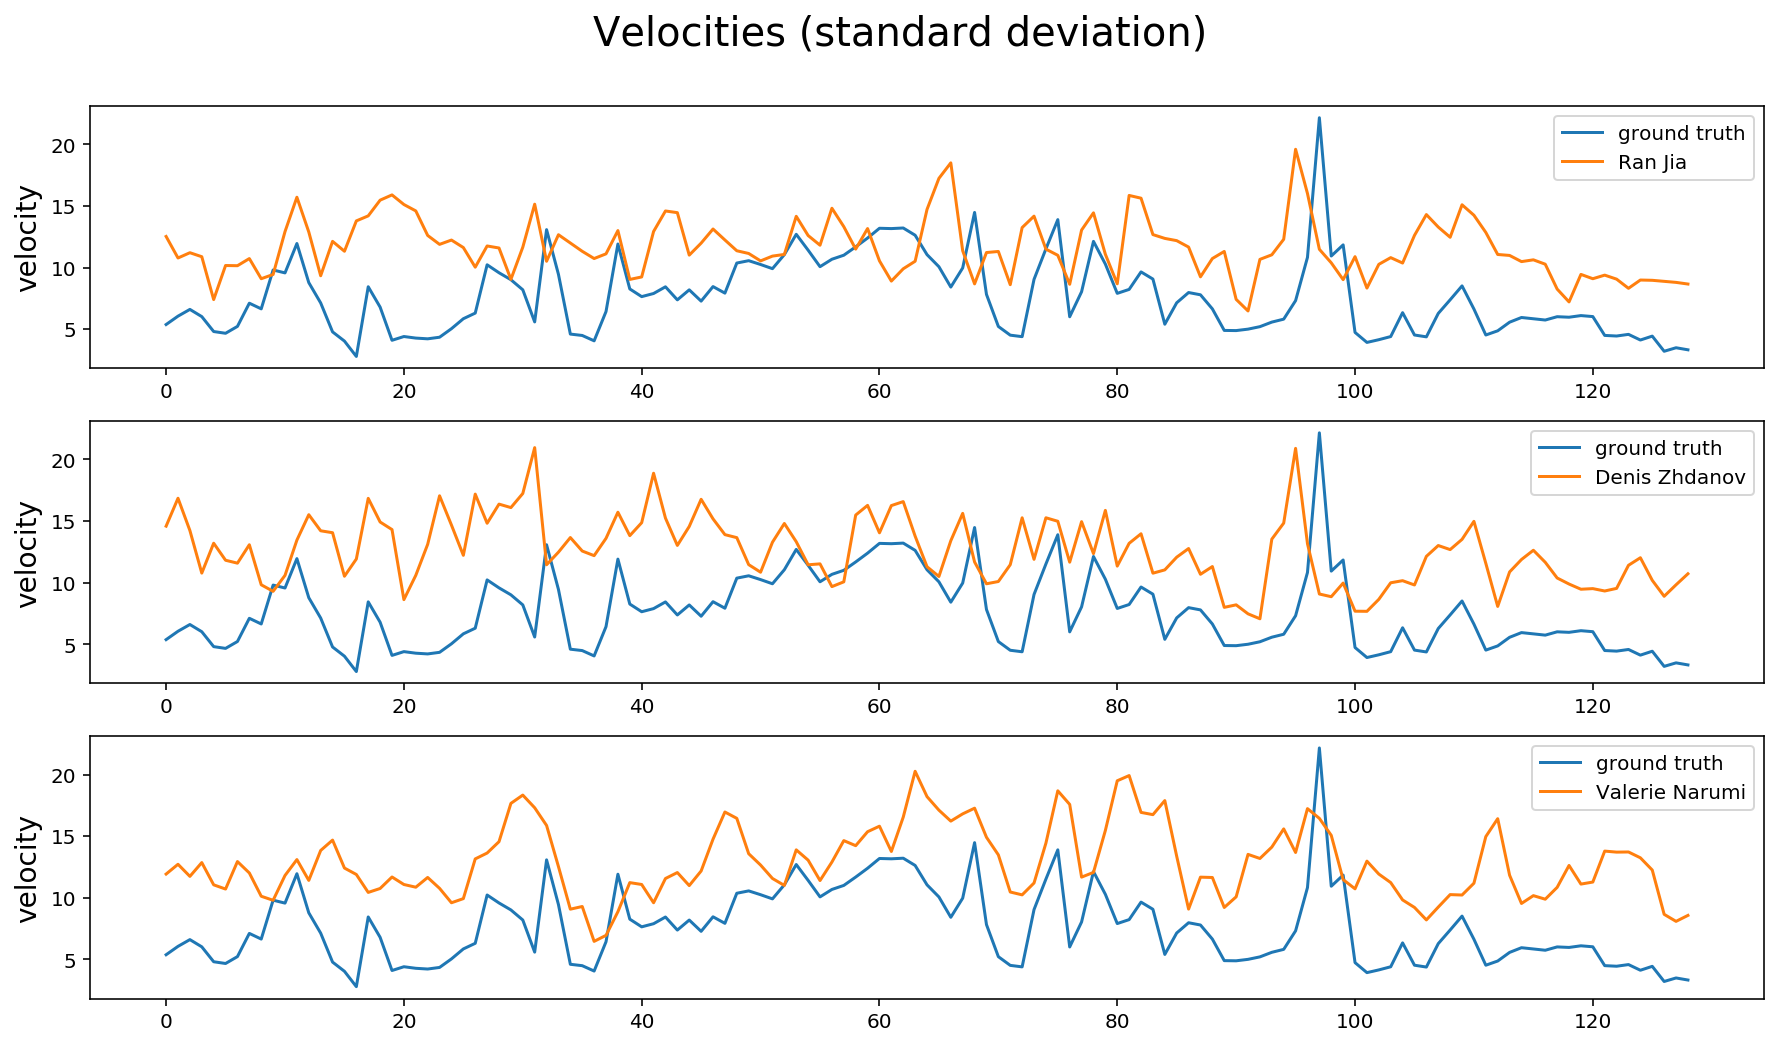

In [6]:
# For each performer, plot the performance data
# against the ground truth.
plt.figure(figsize = (15,8))
for i, mpf in enumerate(res_means):
    plt.subplot(3,1,i+1)
    plt.plot(vel_means[0])
    plt.plot(mpf)
    plt.legend(['ground truth',
                urls['performances'][i]['performer']
               ])
    plt.ylabel("velocity", fontsize = 14)
plt.suptitle("Velocities (mean)", fontsize = 20)
plt.subplots_adjust(top=0.9, wspace = 0.8)
plt.show()

plt.figure(figsize=(15,8))
for i, spf in enumerate(res_stds):
    plt.subplot(3,1,i+1)
    plt.plot(vel_stds[0])
    plt.plot(spf)
    plt.legend(['ground truth',
                urls['performances'][i]['performer']
               ])
    plt.ylabel("velocity", fontsize = 14)
plt.suptitle("Velocities (standard deviation)", fontsize = 20)
plt.subplots_adjust(top=0.9, wspace = 0.8)
plt.show()

The mean of the velocities in some way should give us a measure of the **loudness**, or **force**, of the performance in that point, while the standard deviation sheds some light on its **dynamic range**. It's quite evident that all of the three performances seem to be more forceful than our ground-truth, but it's not as clear how to interpret the standard deviation.

To help us, we will compute and plot the overall means and standard deviations.

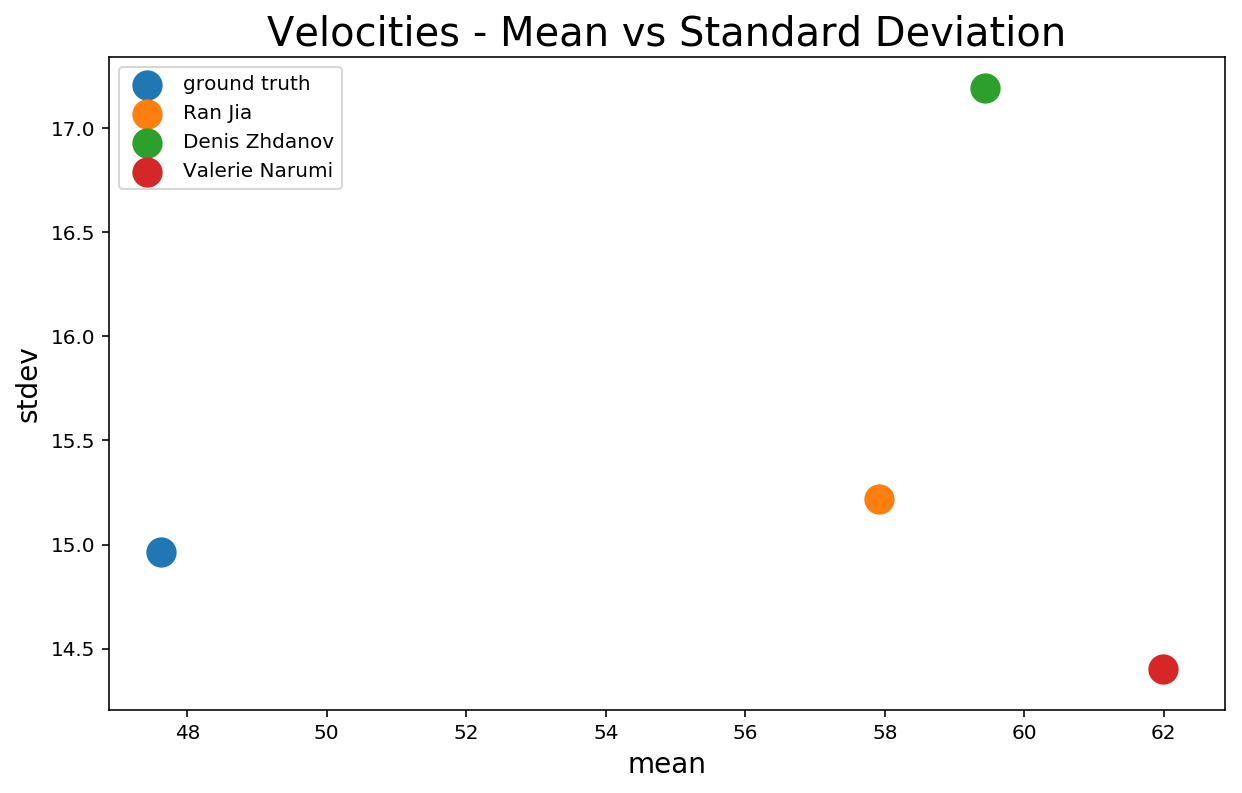

In [7]:
plt.figure(figsize=(10,6))
plt.title("Velocities - Mean vs Standard Deviation", fontsize=20)
for performance in perf_velocities:
    mean = np.mean(performance[0])
    std = np.std(performance[0])
    plt.scatter(mean, std, s = 200)
plt.xlabel("mean", fontsize=14)
plt.ylabel("stdev", fontsize=14)
plt.legend([
    'ground truth',
    urls['performances'][0]['performer'],
    urls['performances'][1]['performer'],
    urls['performances'][2]['performer']
], loc = 2)
plt.show()

As observed before, all the performances are more forceful than the ground truth. Denis Zhdanov appears to be the performer who makes use of the widest dynamic range, while Valerie Narumi has a very high mean measure (meaning her perforance was the most forceful overall) and the lowest measure of standard deviation, meaning very narrow dynamic range (notice though how the scale of the standard deviation doesn't cover a wide span of values).